# **Redis + Feast**: Feature Store Setup on Google Cloud Platform (GCP)

Here we will move through necessary steps to setup an end-to-end Feature Store on GCP with Feast and Redis Enterprise (as the "Online Store").

## Demo ML Application
The demo application will be fusing [google search trends data]() along with [vaccine demand signals]() by state and week. Both datasets are open source and provided free to the public!

The full system will perform the following steps:
- Provision GCP infrastructure
- Compute and backfill feature data from raw data sources
- Build point-in-time correct training datasets from feature data and train a model
- Make online predictions from feature data

Here's a high-level picture of the system architecture:

![architecture](../img/Feast_GCP_Redis_Ray_Demo.png)

The stack will include different tools based on the environment. On GCP, our stack will include the following:

- All model feature definitions will live in a **GitHub** repository (this one).
- Features will be registered to a **Cloud Storage** bucket using the **Feast** SDK and **Cloud Build** for CI/CD.
- **BigQuery** will be the offline source of record for ML features.
- Periodically, a **Cloud Scheduler** job will trigger a **Cloud Function** to materialize the latest features to the online store.
- **Redis Enterprise** will be the online store.

# Installation and Set up

## Install Dependencies

Feast can be installed using pip. This installation includes a Python package as well as a CLI.

In [ ]:
!pip install -r 'feature_store/requirements.txt'
!feast version

**After running this cells, restart the runtime to continue** (Runtime > Restart runtime.)

## Environment Setup

Edit the following values below:

- GOOGLE_APPLICATION_CREDENTIALS: Path to your GCP credentials JSON file.
- PROJECT_ID: Your GCP project identifier.
- PROJECT_NUMBER: Your GCP project number.
- REDIS_CONNECITON_STRING: Your Redis Enterprise connection string --> `host:port`.
- REDIS_PASSWORD: Your Redis Enterprise password.

In [1]:
# **UPDATE THESE** #
%env GOOGLE_APPLICATION_CREDENTIALS=/Users/tyler.hutcherson/Downloads/nifty-time-353221-e1ae0236dfee.json
%env REDIS_CONNECTION_STRING=redis-16188.c285.us-west-2-2.ec2.cloud.redislabs.com:16188
%env REDIS_PASSWORD=Kz8Z8EkqhKQcwwws4XrGEWMwwrAk1SHr
%env PROJECT_ID=nifty-time-353221


env: GOOGLE_APPLICATION_CREDENTIALS=/Users/tyler.hutcherson/Downloads/nifty-time-353221-e1ae0236dfee.json
env: REDIS_CONNECTION_STRING=redis-16188.c285.us-west-2-2.ec2.cloud.redislabs.com:16188
env: REDIS_PASSWORD=Kz8Z8EkqhKQcwwws4XrGEWMwwrAk1SHr
env: PROJECT_ID=nifty-time-353221


## GCP Setup

1. [Create a new project](https://console.cloud.google.com/cloud-resource-manager)
2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)
3. Enable the following APIs:
    1. [Cloud Scheduler](https://console.cloud.google.com/apis/library/cloudscheduler.googleapis.com?q=cloud&id=1d54d828-14ed-4976-959b-3b18cca9e859)
    2. [Cloud Build](https://console.cloud.google.com/apis/library/cloudbuild.googleapis.com?q=cloud&id=9472915e-c82c-4bef-8a6a-34c81e5aebcc)
    3. [Secret Manager]()
    3. [Cloud Functions](https://console.cloud.google.com/apis/library/cloudfunctions.googleapis.com?q=cloud%20functions&id=2174da14-0e34-49ed-9267-e258674e95da)

In [5]:
from repo import config
from utils import DataFetcher, ModelRepo
from utils import file

# Set the GCP Project
! gcloud config set project $config.PROJECT_ID
%env GOOGLE_CLOUD_PROJECT=$config.PROJECT_ID
!echo project_id = $config.PROJECT_ID > ~/.bigqueryrc

Updated property [core/project].
env: GOOGLE_CLOUD_PROJECT=nifty-time-353221


### Create a Cloud Storage bucket
**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
# Only run if your bucket doesn't already exist!
! gsutil mb gs://$config.BUCKET_NAME

### Create a BigQuery dataset
**Only if your dataset doesn't already exist**: Run the following cell to create your BigQuery dataset.

In [3]:
! bq --location=us mk --dataset $config.PROJECT_ID:$config.BIGQUERY_DATASET_NAME

Dataset 'nifty-time-353221:gcp_feast_demo' successfully created.


### Create Feature Store Config



### Create a Cloud Function for Feature Creation & Materialization

We will use a **GCP Cloud Function** to run a feature generation and materialization job.

>Our offline features will be stored in GCP BigQuery. Above, we've already created a dataset `gcp_feast_demo` where our cloud function can load two new tables.

- `gcp_feast_demo.us_weekly_vaccinations` - Weekly vaccination counts across the United States by State.
- `gcp_feast_demo.vaccine_search_trends` - Weekly vaccine search trends series with three search categories (interest, intent, and safety) by US state.


In [ ]:
# Deploy cloud function!
! gcloud functions deploy feast-update-features \
    --source=$(pwd) \
    --entry-point=main \
    --memory=1024MB \
    --allow-unauthenticated \
    --runtime python38 \
    --trigger-resource feast-schedule \
    --trigger-event google.pubsub.topic.publish \
    --timeout 540s \
    --set-build-env-vars GOOGLE_FUNCTION_SOURCE="materialize.py" \
    --set-env-vars PROJECT_ID=$config.PROJECT_ID

### Create a Cloud Scheduler Job
To trigger the cloud function, we will schedule a job with Cloud Scheduler. This will run daily and is configurable.

In [ ]:
# Create Cloud Scheduler Job
! gcloud scheduler jobs create pubsub feast-daily-job \
    --location us-east1 \
    --schedule "0 22 * * *" \
    --topic feast-schedule \
    --message-body "This job schedules feature materialization once a day."

## Feature Store Setup

### Create Feature Store Configuration

In [4]:
import pickle
from feast import RepoConfig, FeatureStore
from google.cloud import storage

# Create a feature store repo config
repo_config = RepoConfig(
    project="feature_store",
    # Cloud Storage Blob for the Registry
    registry=f"gs://{config.BUCKET_NAME}/data/registry.db",
    # Google Cloud Project -- GCP
    provider="gcp",
    # Redis Enterprise as the Online Store
    online_store={
        "type": "redis",
        "connection_string": f"{config.REDIS_CONNECTION_STRING},password={config.REDIS_PASSWORD}"
    },
    entity_key_serialization_version=2
)

# Host the config in cloud storage
file.upload_pkl_to_gcs(repo_config, config.BUCKET_NAME, config.REPO_CONFIG)

### Generate Initial Features

In [ ]:
from materialize import (
    generate_vaccine_count_features,
    generate_vaccine_search_features,
    bigquery,
    storage
)

# GCP client objects
client = bigquery.Client()

# Generate Weekly Vaccine Count Features
generate_vaccine_count_features(
    client,
    f"{config.PROJECT_ID}.{config.BIGQUERY_DATASET_NAME}.{config.WEEKLY_VACCINATIONS_TABLE}"
)

# Generate Vaccine Search Features
generate_vaccine_search_features(
    client,
    f"{config.PROJECT_ID}.{config.BIGQUERY_DATASET_NAME}.{config.VACCINE_SEARCH_TRENDS_TABLE}"
)

### Create Feature Store

Last step before we can utilize our store is to create the Feature Store by registering the feature definitions and entities in `features.py` and perform the initial materialization.

In [ ]:
# Apply to create a feature store in GCP
! python apply.py

# Fetching Historical Data

Now that our features are registered in Feast, we can use Feast to generate a training dataset. To do this, we need an entity dataframe, alongside the list of features we want.

To make things simpler, we registered a `FeatureService` for both model training and serving.

In [ ]:
from feast import FeatureStore

# Load fs
store = FeatureStore(config=repo_config)
# Load data fetcher
data_fetcher = DataFetcher(store)

In [ ]:
# Fetch Historical Training Data
ds = data_fetcher.get_training_data()

In [ ]:
virginia = ds[ds.state == 'Virginia']

In [ ]:
virginia.sort_values('event_timestamp', axis=0, inplace=True)

In [ ]:
virginia.head()

In [ ]:
virginia.tail()

In [ ]:
# Clean up any nulls
ds.dropna(inplace=True)
ds.sort_values(['event_timestamp', 'state'], axis=0, inplace=True)

In [ ]:
virginia = ds[ds['state'] == 'Virginia']

virginia.weekly_vaccinations_count.describe()

In [ ]:
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_2_vaccine_interest')

In [ ]:
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_2_vaccine_safety')

## Training a model

Now, we can use our features to train a model:

In [ ]:

# forecast monthly births with xgboost
import warnings
warnings.filterwarnings('ignore')
from time import sleep
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from numpy import asarray, array
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder



# split a timeseries dataset into train/test sets by date
def train_test_split(data: pd.DataFrame, n_test_weeks):
    split_point = data.event_timestamp.max() - timedelta(weeks=n_test_weeks)
    train = data[data.event_timestamp <= split_point]
    test = data[data.event_timestamp > split_point]
    train.drop('event_timestamp', axis=1, inplace=True)
    test.drop('event_timestamp', axis=1, inplace=True)
    return train, test

# fit an xgboost model
def xgboost_train(train):
    # split into input and output columns
    trainX, trainy = train.iloc[:, :-1], train.iloc[:, -1]
    # make model
    ordinal_encoder = make_column_transformer(
        (
            OrdinalEncoder(dtype=int),
            make_column_selector(pattern="state"),
        ),
        remainder="passthrough",
    )
    model = make_pipeline(
        ordinal_encoder,
        XGBRegressor(
            random_state=42,
            objective="count:poisson",
            tree_method="hist",
            enable_categorical=True,
            n_estimators=250,
            max_depth=4
        )
    )
    model.fit(trainX, trainy)
    return model

# walk-forward validation for timeseries data
def create_model(data, n_test_weeks):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test_weeks)
    testX, testy = test.iloc[:, :-1], test.iloc[:, -1]
    # train
    model = xgboost_train(train)
    # predict
    predictions = model.predict(testX)
    error = mean_absolute_error(testy, predictions)
    return error, testy.to_numpy(), predictions, model


In [ ]:
features = [
    "state",
    # "lag_1_vaccine_interest",
    "lag_2_vaccine_interest",
    "lag_1_vaccine_intent",
    "lag_2_vaccine_intent",
    "lag_1_vaccine_safety",
    "lag_2_vaccine_safety",
    # "lag_1_weekly_vaccinations_count",
    # "lag_2_weekly_vaccinations_count"
]

# Train!
columns = ["event_timestamp"] + features + ["weekly_vaccinations_count"]
mae, y, yhat, model = create_model(ds[columns], n_test_weeks=1)


# plot expected vs preducted
print('MAE: %.3f' % mae)
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
# Explore feature importance
for feature, imp in zip(features, model[-1].feature_importances_):
    print(feature, imp)

## Saving and deploying the model

First we save the model to storage.

In [ ]:
# Use the model repo helper class
host, port = config.REDIS_CONNECTION_STRING.split(":")
model_repo = ModelRepo(host, port, config.REDIS_CONNECTION_STRING)
await model_repo.setup()

In [ ]:
# Save model

version = await model_repo.save_version(model)
print(f"Saved model version {version}")

# Low latency inference

To make a prediction in real-time, we need to do the following:

1. Fetch our features from Redis using the Feast client
2. Pass these features to our model
3. Return these predictions to the user

![Feast landing page, blog post - [Archive].png](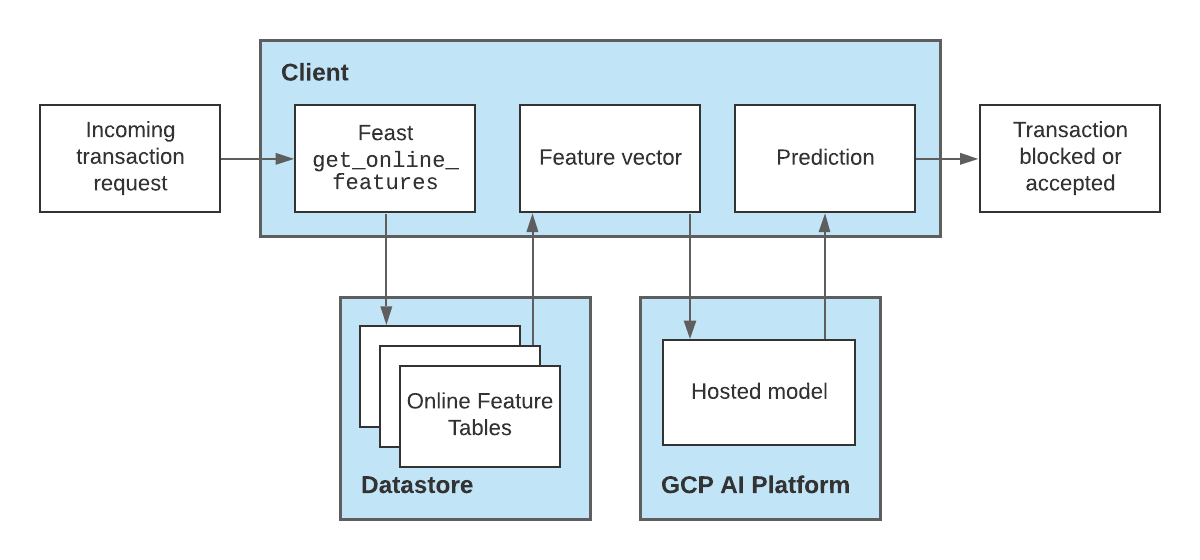)


In [ ]:
# Fetch online feature
online_feature = data_fetcher.get_online_data({"state": "Virginia"})

In [ ]:
# Test the vaccine demand
from serve.vaccine_demand import VaccineDemand

vaccine_demand = VaccineDemand(model, repo_config, cols=features)

## Trouble Shooting


### Configure BigQuery permissions

You might also need to give your cloud function permission to access your BigQuery dataset. To do this:

1. Open your dataset in BigQuery.
2. Hover over the plus icon, and click "share dataset."
3. In the pop-up, enter your project's service account email. This should be `[PROJECT_ID]@appspot.gserviceaccount.com`. 
4. Select permission "Can Edit" and confirm.

## Run the workflow

If you want to test the workflow manually:

1. Open the **Cloud Scheduler** page in the console.
2. Click the ‘Run Now’ button in the feast-daily-job row.
3. Open the **Cloud Function** page in the console.
4. Open your **Cloud Function** (feast-update-features.)
5. Open the Logs tab to see the latest run of your cloud function.

# Next steps

We have just built an end-to-end system using Feast and Redis Enterprise in GCP.


This system generates realtime predictions using up to date feature values from our model.

Next steps that you can take after completing this tutorial include:

- Check your repo into git to enable collaboration with your team.
- Use this tutorial to bootstrap a model for your use case by editing features / model.
- Incorporate the code in this tutorial into your company's batch pipelines by creating stages that perform feature creation and materialization.

# Cleanup

If you want to clean up the resources created during this tutorial, run the following cells:


In [ ]:
! bq rm -t -f $config.BIGQUERY_DATASET_NAME'.'$config.WEEKLY_VACCINATIONS_TABLE
! bq rm -t -f $config.BIGQUERY_DATASET_NAME'.'$config.VACCINE_SEARCH_TRENDS_TABLE
! bq rm -r -f -d $config.BIGQUERY_DATASET_NAME
! gcloud functions delete feast-update-features
! gcloud scheduler jobs delete feast-daily-job --project $PROJECT_ID
! python teardown.py

In [ ]:
! echo $config.PROJECT_ID'.'$config.BIGQUERY_DATASET_NAME